## Data Exploration and Visualization
My main goal of this project is to create a model that can beat the Vegas odds in a real world return on risk way.  To understand what the baseline is that we are trying to beat, I will visualize how predictive the Vegas odds can be.  First I will import the necessary libraries and dataframe created in the previous notebook, as well as create a few new variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
pickle_in=open("cleaned_data.pickle","rb")
df=pickle.load(pickle_in)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 225)
# This section creates a few new variables
# home_margin is the margin of victory or defeat for the home team
df['home_margin']=df.home_score-df.away_score
# home_hotter is a dummy where 1 means that the home team has won a 
# greater percentage of their recent games
df['home_hotter']=df.home_streak>=df.away_streak
# open_vegas_predict is a dummy where 1 means that the home team was
# favored when odds makers started the betting
df['open_vegas_predict']=df.home_prob_open>.5
# change_vegas_predict is a dummy where 1 means that the betting 
# market moved for the home team from during the time when bets were placed
df['change_vegas_predict']=df.home_prob_change>0
# vegas_predict is a dummy variable where 1 means that Vegas picks the
# home team at the start of the game
df['vegas_predict']=df.home_prob_close>=.5

When the bookmakers begin the betting on a game, they start with opening odds which are captured in this dataset by the variables "home_money_open" and "away_money_open".  Then there is a period of time where bets are places and naturally the odds can change based on what the broader betting market supply and demand calls for.  Then at the start of the game, the betting stops and we are left with the variables "home_money_close" and "away_money_close".  With this information we can assess how good the bookmakers are at predicting and how much the wisdom of the crowd adds to that predictiveness.  One major note is that odds can change not just on supply and demand for bets but also as a result of last minute coaching or injury news; there for the change in the odds is not necessarily singularly a reflection of the wisdom of the broader betting market.

Below is a function that calculates the return on risk for betting on each game and returns a result such that a value of 4 means that a total risk of \\$1,000 would return \\$40 in winnings. However the function returns two different return on risk values.  The way that the wagers are set up, betting on the favorite requires risking more than \\$100 in order to recieve a \\$100 payout.  What I am calling the "natural return" is the return on risk if you were to bet these different amounts on the games.  What I am calling the "equal bet return" is the return if you were to  risk the same amount of money on each game.  This will come into play later in the project as the models will sometimes bet on the underdog and thus recieve a larger payout.

In [2]:
def calc_return(X_analyse):
    total_risk=[]
    total_reward=[]
    equal_bet_return=[]
    for i in range(len(X_analyse)):
        k=pd.DataFrame(X_analyse.iloc[i]).transpose()
        k.reset_index(drop=True,inplace=True)
        if int(k.preds[0])==1:
            if int(k.real[0])==1:
                if int(k.home_money[0])<0:
                    risk=k.home_money[0]
                    reward=100
                else:
                    risk=-100
                    reward=k.home_money[0]
            else:
                if k.home_money[0]<0:
                    risk=k.home_money[0]
                    reward=k.home_money[0]
                else:
                    risk=-100
                    reward=-100
        else:
            if int(k.real[0])==0:
                if k.away_money[0]<0:
                    risk=k.away_money[0]
                    reward=100
                else:
                    risk=-100
                    reward=k.away_money[0]
            else:
                if k.away_money[0]<0:
                    risk=k.away_money[0]
                    reward=k.away_money[0]
                else:
                    risk=-100
                    reward=-100
        total_risk.append(risk)
        total_reward.append(reward)
        equal_bet_winnings=reward/-risk*100
        equal_bet_return.append(equal_bet_winnings)
    natural_ror=round(-np.mean(total_reward)/np.mean(total_risk)*100,2)
    equal_bet_ror=round(np.mean(equal_bet_return),2)
    return natural_ror,equal_bet_ror

Below is the analysis using the opening odds, which basically evaluates the predictiveness of the bookmaker's original odds.  The chart depicts the question "If the odds of the home team winning are 70%, what percent of the time does the home team actually win?".  The orange line represents the case where the answer to that question is exactly 70% and the blue line is what actually happened.  As we can see, the r-squared between these two lines is a high value of .77, meaning that on a large sample set the Vegas odds are quite good at detemining the percentage of winners and losers.  The accuracy score is the percentage of games that Vegas picked correctly, and the returns on risk are the real world winnings that a bettor would have realized if he had bet with Vegas on each game.  As we can see there is a slight advantage to betting with the odds makers, even before the broader betting market weighs in.

Accuracy Score:  59.81
Natural Return on Risk:  1.47 %
Equal Return on Risk:  1.59 %
Implied Odds vs Percent of Games r-squared: 0.77


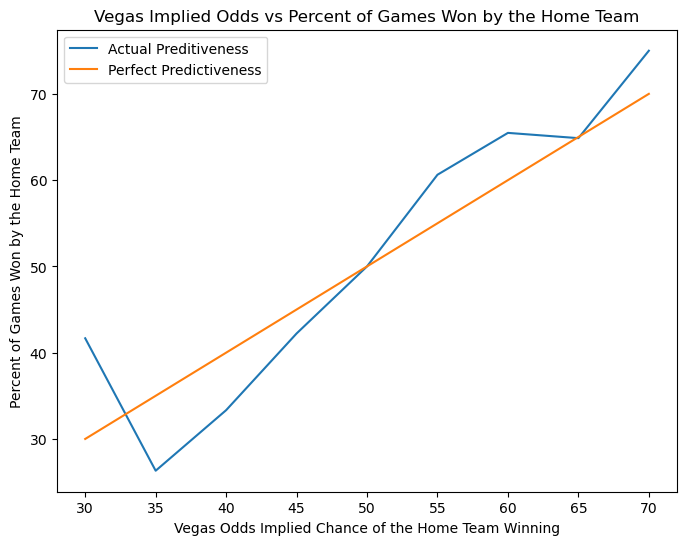

In [3]:
a=pd.DataFrame([])
x=[30,35,40,45,50,55,60,65,70]
y=[30,35,40,45,50,55,60,65,70]
for i in [.3,.35,.4,.45,.5,.55,.6,.65,.7]:
    holder=df[df.home_prob_open>i]
    holder=holder[holder.home_prob_open<i+.05]
    if len(holder>0):
        b=sum(holder.home_win)/len(holder)
    else:
        b=0
    a=a.append(pd.DataFrame({'bin_num':i*100,'pct':b*100},index=[0]),ignore_index=True)
plt.figure(figsize=(8,6))
plt.plot(x,a.pct,label="Actual Preditiveness")
plt.plot([30,70],[30,70],label='Perfect Predictiveness')
plt.xlabel('Vegas Odds Implied Chance of the Home Team Winning')
plt.ylabel('Percent of Games Won by the Home Team')
plt.legend()
plt.title('Vegas Implied Odds vs Percent of Games Won by the Home Team')
bet_w_vegas_open=df[['open_vegas_predict','home_win','home_money_close','away_money_close']].copy()
bet_w_vegas_open=bet_w_vegas_open.rename(columns={'open_vegas_predict':'preds','home_win':'real',
                                       'home_money_close':'home_money','away_money_close':'away_money'})
bet_w_vegas_open.preds=bet_w_vegas_open.preds*1
nat,eq=calc_return(bet_w_vegas_open)
print('Accuracy Score: ',round(accuracy_score(bet_w_vegas_open.real,bet_w_vegas_open.preds) * 100,2))
print('Natural Return on Risk: ',nat,'%')
print('Equal Return on Risk: ',eq,'%')
print('Implied Odds vs Percent of Games r-squared:',round(r2_score(y,a.pct),2))

Below is a chart showing how the movement in odds from the open to close corresponds with the percentage of games that the home team wins.  This chart makes sense intuitively because if the odds move in the home team's favor, the home team is expected to win a greater percentage of games.

Text(0.5, 1.0, 'Change in Vegas Implied Odds vs Percent of Games Won by the Home Team')

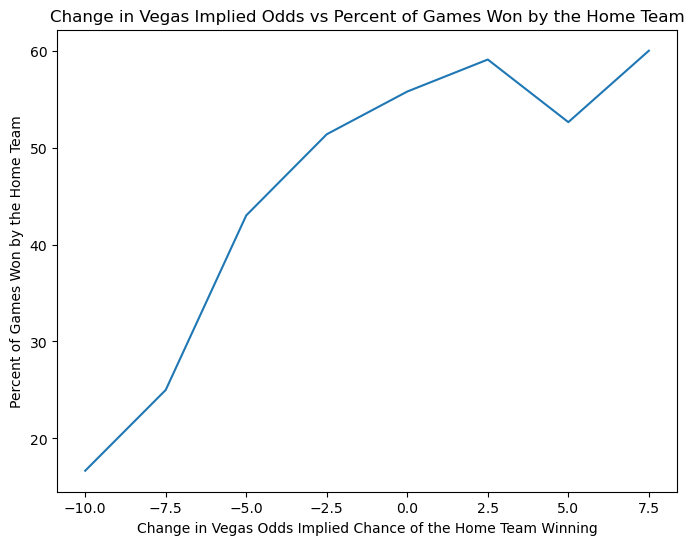

In [4]:
a=pd.DataFrame([])
for i in [-.1,-.075,-.05,-.025,0,.025,.05,.075]:
    holder=df[df.home_prob_change>i]
    holder=holder[holder.home_prob_change<i+.025]
    if len(holder>0):
        b=sum(holder.home_win)/len(holder)
    else:
        b=0
    a=a.append(pd.DataFrame({'bin_num':i*100,'pct':b*100},index=[0]),ignore_index=True)
plt.figure(figsize=(8,6))
plt.plot(a.bin_num,a.pct)
#plt.plot([30,70],[30,70],label='Perfect Predictiveness')
plt.xlabel('Change in Vegas Odds Implied Chance of the Home Team Winning')
plt.ylabel('Percent of Games Won by the Home Team')
plt.title('Change in Vegas Implied Odds vs Percent of Games Won by the Home Team')

Below is the same analysis as above except for the closing odds.  The closing odds are the odds right before game time and can be seen as the summation of the total predictiveness of the broad betting market.  As we can see, all of the metrics have improved.  This makes sense because these odds include "more wisdom" than the original odds.  These results are also what I will be comparing my final model to.

Accuracy Score:  61.07
Natural Return on Risk:  2.53 %
Equal Return on Risk:  3.11 %
Implied Odds vs Percent of Games r-squared: 0.78


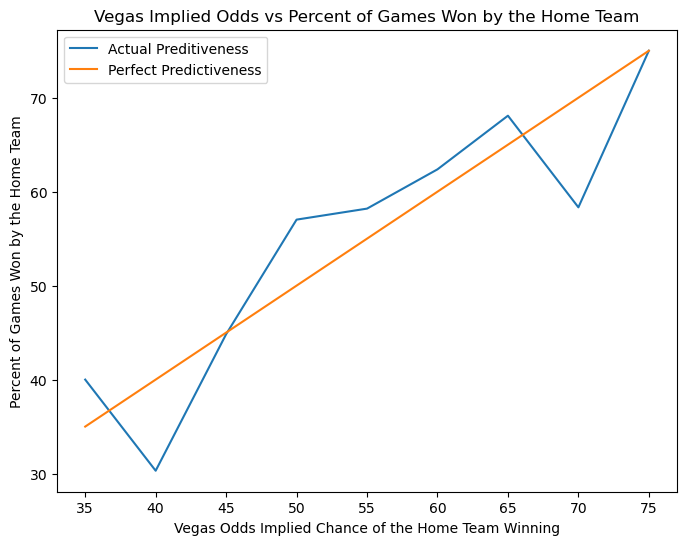

In [5]:
a=pd.DataFrame([])
x=[35,40,45,50,55,60,65,70,75]
y=[35,40,45,50,55,60,65,70,75]
for i in [.35,.4,.45,.5,.55,.6,.65,.7,.75]:
    holder=df[df.home_prob_close>i]
    holder=holder[holder.home_prob_close<i+.05]
    if len(holder>0):
        b=sum(holder.home_win)/len(holder)
    else:
        b=0
    a=a.append(pd.DataFrame({'bin_num':i*100,'pct':b*100},index=[0]),ignore_index=True)
plt.figure(figsize=(8,6))
plt.plot(x,a.pct,label="Actual Preditiveness")
plt.plot([35,75],[35,75],label='Perfect Predictiveness')
plt.xlabel('Vegas Odds Implied Chance of the Home Team Winning')
plt.ylabel('Percent of Games Won by the Home Team')
plt.legend()
plt.title('Vegas Implied Odds vs Percent of Games Won by the Home Team')
bet_w_vegas_close=df[['vegas_predict','home_win','home_money_close','away_money_close']].copy()
bet_w_vegas_close=bet_w_vegas_close.rename(columns={'vegas_predict':'preds','home_win':'real',
                                       'home_money_close':'home_money','away_money_close':'away_money'})
bet_w_vegas_close.preds=bet_w_vegas_close.preds*1
nat,eq=calc_return(bet_w_vegas_close)
print('Accuracy Score: ',round(accuracy_score(bet_w_vegas_close.real,bet_w_vegas_close.preds) * 100,2))
print('Natural Return on Risk: ',nat,'%')
print('Equal Return on Risk: ',eq,'%')
print('Implied Odds vs Percent of Games r-squared:',round(r2_score(y,a.pct),2))

Below is a set up for testing how useful the final model is.  Here I split the data into 50 different random groups of 10% of the examples.  For each random split, I calculate the percentage of games that the Vegas odds got correct, the percent return on risk for natural betting and the percent return on risk for equal wager betting.  I then export these in order to be compared to the results of my best performing model. In order to have as fair and meaninful of a comparison as possible, I have used the same random states and test split sizes for every trial going forward.  The idea behind this is to use the Welch's t-test to determine if there is a statistically significant difference between Vegas's predictions and my final model's predicitons.

In [6]:
baseline_accuracy=[]
baseline_natural_ror=[]
baseline_equal_ror=[]
for i in range(0,50):
    sample=pd.DataFrame([])
    vegas_correct=0
    shuf_df=df.copy()
    sample=shuf_df.sample(frac=.1,random_state=i)
    sample.reset_index(drop=True,inplace=True)
    bets=pd.DataFrame([])
    for j in range(len(sample)):
        if sample.vegas_predict[j]*1==1:
            if sample.home_win[j]==1:
                vegas_correct+=1
                bets=bets.append(pd.DataFrame({'preds':1,'real':1,'home_money':sample.home_money_close[j],
                                     'away_money':sample.away_money_close[j]},index=[0]),ignore_index=True)
            else:
                bets=bets.append(pd.DataFrame({'preds':1,'real':0,'home_money':sample.home_money_close[j],
                                     'away_money':sample.away_money_close[j]},index=[0]),ignore_index=True)
        else:
            if sample.home_win[j]==0:
                vegas_correct+=1
                bets=bets.append(pd.DataFrame({'preds':0,'real':0,'home_money':sample.home_money_close[j],
                                     'away_money':sample.away_money_close[j]},index=[0]),ignore_index=True)
            else:
                bets=bets.append(pd.DataFrame({'preds':0,'real':1,'home_money':sample.home_money_close[j],
                                     'away_money':sample.away_money_close[j]},index=[0]),ignore_index=True)
    baseline_accuracy.append(vegas_correct/len(sample)*100)
    nat,equal=calc_return(bets)
    baseline_natural_ror.append(nat)
    baseline_equal_ror.append(equal)
pickle_out=open("baseline_accuracy.pickle","wb")
pickle.dump(baseline_accuracy,pickle_out)
pickle_out.close()
pickle_out=open("baseline_natural_ror.pickle","wb")
pickle.dump(baseline_natural_ror,pickle_out)
pickle_out.close()
pickle_out=open("baseline_equal_ror.pickle","wb")
pickle.dump(baseline_equal_ror,pickle_out)
pickle_out.close()

Below is an interesting visualization of the effect that the quality of a starting pitcher and a teams recent hitting performance have on the home team's odds of winning.  "Launch Speed" is a new metric that arose with the advancement of camera technology and is the speed (in miles per hour) that a batted ball leaves the hitter's bat.  A higher value means that the ball was hit harder.  The x_axis is the average launch speed of balls hit against a pitcher during the recent past.  A lower value can be interpreted as a pitcher being better at forcing batters into hitting weaker balls.  The y-axis is the opposing team's recent slugging percentage.  Slugging Percentage is a metric in which a higher value means that a team's average at bat results in more bases reached.  The color of the plot is the home team's probability of winning accoring to the Vegas odds.

In the first plot we can see that more of the yellow points (representing the home team's chance of winning) are concentrated in the lower left of the graph.  This makes sense because as the home team's pitcher is better (lower value) and the opposing team's batters are worse (lower value), the home team's chance of winning increases.  We can see the opposite effect (higher concentration of yellow dots in the upper right) in the second graph when the teams are reversed, although the relationship appears to be slightly weaker

TypeError: axis() got an unexpected keyword argument 'aspect'

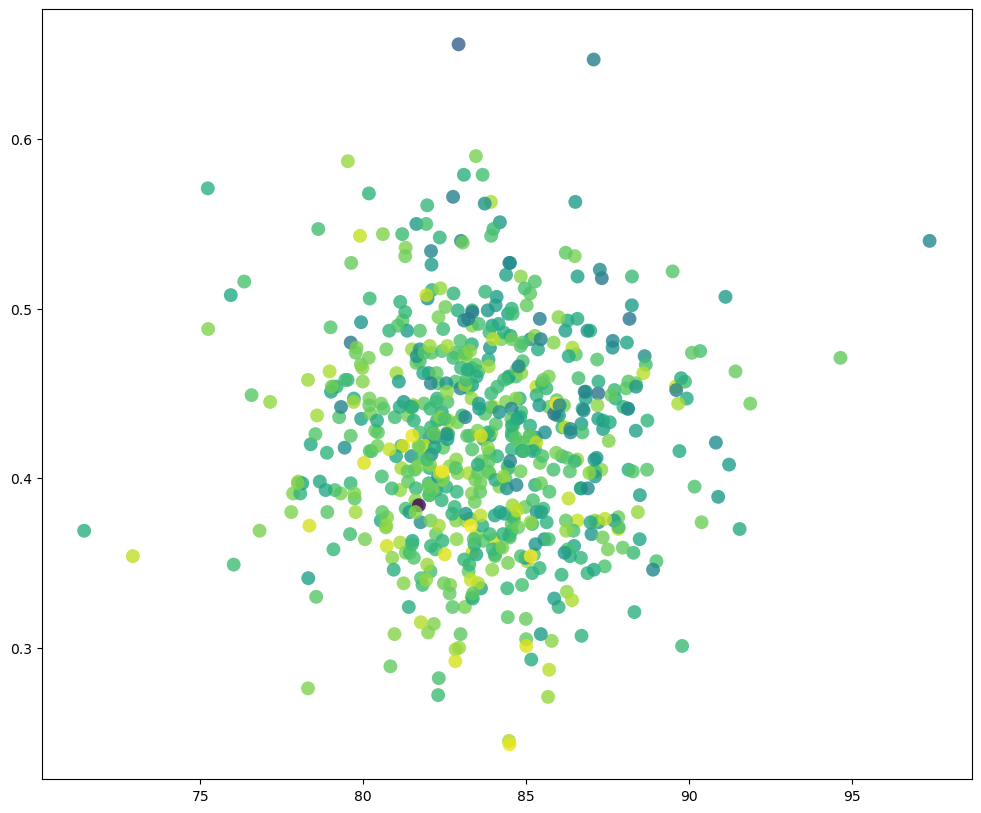

In [7]:
plt.figure(figsize=(12,10))
plt.scatter(df.home_starter_launch, df.away_bat_slg, label=None,
            c=df.home_prob_close*100, cmap='viridis',
            linewidth=0, alpha=.8,s=100)
plt.axis(aspect='equal')
plt.xlabel('Home Starter Average Batted Ball Launch Speed')
plt.ylabel('Away Team Recent Slugging Percent')
plt.xlim(75,92)
plt.colorbar(label='Percent Chance')
plt.clim(30,70)
plt.title('Change of Home Team Winning')
plt.figure(figsize=(12,10))
plt.scatter(df.away_starter_launch, df.home_bat_slg, label=None,
            c=df.home_prob_close*100, cmap='viridis',
            linewidth=0, alpha=.8,s=100)
plt.axis(aspect='equal')
plt.xlabel('Away Starter Average Batted Ball Launch Speed')
plt.ylabel('Home Team Recent Slugging Percent')
plt.colorbar(label='Percent Chance')
plt.xlim(73,92)
plt.clim(30,70)
plt.title('Change of Home Team Winning')

#### For the next section please see the notebook titled "Comparing_Models"